## 3. Are genes that are DE in the mutant compared to the background involved in growth? 

We clustered the genes that are DE in time in the backrgound strain Pad4 and looked for functional enrichment in these clusters. We compared the genes that are differentially expressed in the mutant compared to this background and found that in general, the expression level of these genes is lower than in the background. 

Because we also observe a growth phenotype in the mutant, we now want to w=know whether the genes that are differentially expressed in the mutant compared to the background are involved in growth. For this, we determine whether the DE egenes are enriched for putative targets of key growth-regulators, specifically PIF4, but also BZR1 and ARF6.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles

import sys
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

First we load the sets of putative targets of the three TFs and compare them:

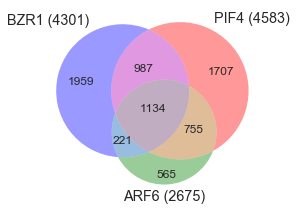

In [3]:
subset2color = {'PIF4': 'red', 'ARF6':'green', 'BZR1':'blue'}

name_list   = ['BZR1', 'PIF4', 'ARF6'] # use same order as in paper
subset_list = []
label_list  = []
color_list  = []
for subset_name in name_list:
    #copy-pasted from excel files, hence the split by '\r'
    subset = set([x.strip() for x in open(subset_name+'.txt').read().upper().split('\r')]) 
    
    subset_size = len(subset)
    subset_list.append(subset)
    color_list.append(subset2color[subset_name])
    label_list.append(subset_name+' ('+str(subset_size)+')')
    
plt.figure(figsize=(4,4))
venn = venn3(subset_list, set_labels = label_list, set_colors = color_list)

    
plt.show()

Now, for the two mutants, we determine for each timepoint the amount of overlap with putative targets of one or more TFs. Hence we not only look at putative targets of one TF but also those that are shared by two or three TFs.
We plot the percentages of overlap in a histogram with colors matching the Venn diagram.

In [ ]:
#mapping from transcripts to probes (copied to 2.scatterplot_DEGs_mutant_vs_bkgr):
import glob
import pickle

def homogenize_geneID(string):
    return string.strip().upper().split('.')[0]


# make dict with transcript_id --> probeset_id mapping
def update_transcript2probe(fname, t2p, all_probes):
    lines = open(fname).readlines()[1:]
    for line in lines:
        #print line
        data        = line.strip().split('\t')
        probe       = int(data[0])
        transcripts = [homogenize_geneID(x) for x in data[1].split(';')]
        
        for t in transcripts:
            t2p[t] = probe
            all_probes.add(probe)
            
    return t2p, all_probes

dirnameStrains = 'data/reanalysisStrains/'
transcript2probe = {}
all_probes = set([])
for fname in glob.glob(dirnameStrains+'*_vs_*.txt'):
    transcript2probe, all_probes = update_transcript2probe(fname, transcript2probe, all_probes)
    print len(transcript2probe.keys())
    pickle.dump(transcript2probe, open('pickles/transcript2probes.pickled', 'w'))
    pickle.dump(all_probes, open('pickles/all_probes_set.pickled', 'w'))
    

In [ ]:
gene_list_combis = [['BZR1', 'regulated_by_BZR1'], ['BZR1', 'PIF4'], ['PIF4', 'regulated_by_PIF']]
probesets_combis = []
for gene_list in gene_list_combis:
    subsets = []
    for index, name_selection in enumerate(gene_list):
        # get selected transcripts (e.g. TF targets)
        subset = set([homogenize_geneID(x) for x in open('gene_lists/'+name_selection+'.txt', 'U')])

        #convert these geneIDs to probeids
        subset_probes = set([])
        Nunknown = 0
        for transcript_id in subset:
            if transcript2probe.has_key(transcript_id):
                subset_probes.add(transcript2probe[transcript_id]) 
        subsets.append(subset_probes)
    probesets_combis.append(subsets)
    
                
for mut in muts:
    # collect all probes that are a DEG when comparing the mutant to the background
    #for all timepoints
    all_probes = set([])
    for T in timepoints:
        all_probes = all_probes.union(pickle.load(\
                    open(dirnameStrains+'pickles/'+T+'_'+bkgr+'_vs_'+mut+'.probes_as_set')))
        print len(all_probes)
    
    for index, subset_names in enumerate(gene_list_combis):
        probesets = [all_probes]+probesets_combis[index]
        labels    = ['DEGs '+mut]+subset_names
        
        name = mut
        for subset_name in subset_names:
            name+=' '+subset_name
        
        plt.figure()
        plt.title(name)
        venn = venn3_unweighted(probesets, set_labels = labels)
        plt.savefig('Pad4_NEW/Venn_diagrams/VENN_'+name.replace(' ', '-')+'.eps')
        
    

In [ ]:
gene_list_TFtargets = ['BZR1', 'PIF4', 'ARF6']
probesets_TFtargets = []
labels = []

for index, name_selection in enumerate(gene_list_TFtargets):
    # get selected transcripts (e.g. TF targets)
    subset = set([homogenize_geneID(x) for x in open('gene_lists/'+name_selection+'.txt', 'U')])   
    #convert these geneIDs to probeids
    subset_probes = set([])
    Nunknown = 0
    for transcript_id in subset:
        if transcript2probe.has_key(transcript_id):
            subset_probes.add(transcript2probe[transcript_id]) 
    print name_selection, len(subset), 'genes,', len(subset_probes),'probes'
    labels.append(name_selection+'\n'+str(len(subset_probes)))
    
    probesets_TFtargets.append(subset_probes)

name = ''
for subset_name in gene_list_TFtargets:
    name+=' '+subset_name

plt.figure()
plt.title(name)
venn = venn3_unweighted(probesets_TFtargets, set_labels = labels)
plt.savefig('Pad4_NEW/Venn_diagrams/VENN_'+name.replace(' ', '-')+'.eps')


for mut in muts:
    # collect all probes that are a DEG when comparing the mutant to the background
    #for all timepoints
    DEG_probes = set([])
    for T in timepoints:
        DEG_probes = DEG_probes.union(pickle.load(\
                    open(dirnameStrains+'pickles/'+T+'_'+bkgr+'_vs_'+mut+'.probes_as_set')))
    print '*',len(DEG_probes), 'DEGs in all timepoints for', mut

    intersected_probesets = []
    labels = []
    for TFidx, TFprobeset in enumerate(probesets_TFtargets):
        labels.append(gene_list_TFtargets[TFidx]+'\n'+str(len(TFprobeset.intersection(DEG_probes))))
        print gene_list_TFtargets[TFidx], len(TFprobeset), len(TFprobeset.intersection(DEG_probes))
        intersected_probesets.append(TFprobeset.intersection(DEG_probes))
     

    name = 'Intersection DEGs '+mut
    plt.figure()
    plt.title(name)
    venn = venn3_unweighted(intersected_probesets, set_labels = labels)
    plt.savefig('Pad4_NEW/Venn_diagrams/VENN_'+name.replace(' ', '-')+'.eps')
    